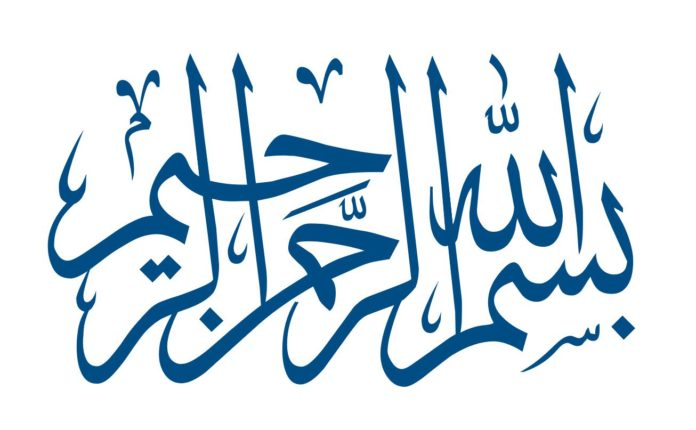

# DQN Blockchain

In [1]:
import pandas as pd
import numpy as np
import os
import sys, getopt
import collections
import subprocess
import pickle
import logging
import copy

import torch

from BlockchainEnvironment import BlockchainEnvironment
from Agent import Agent
from collections import namedtuple, deque

logger = logging.getLogger()
logger.setLevel(logging.INFO)


In [2]:
type_ = "AIH"

In [3]:
#Environtment
env = BlockchainEnvironment(type_)

In [16]:
action = (-0.0004001, 0.140635)
prefix = "test"
step_type = "propose"
i_episode = 100
next_state, reward, done, _info = env.step(action, prefix, step_type, i_episode)

INFO:root:b'> Task :simulator:compileJava UP-TO-DATE\n'
INFO:root:b'> Task :simulator:processResources NO-SOURCE\n'
INFO:root:b'> Task :simulator:classes UP-TO-DATE\n'
INFO:root:b'\n'
INFO:root:b'> Task :simulator:run\n'
INFO:root:b'[124, 160, 6, 550, 194, 408, 168, 468, 282, 228, 557, 435, 59, 394, 242, 38, 405, 180, 255, 280, 198, 107, 239, 311, 505, 212, 416, 233, 406, 344, 17, 174, 57, 580, 262, 541, 547, 306, 39, 490, 579, 70, 71, 436, 293, 357, 334, 243, 366, 499, 312, 576, 410, 165, 469, 19, 31, 82, 112, 79, 412, 534, 434, 148, 122, 449, 136, 223, 190, 272, 14, 131, 205, 28, 142, 178, 121, 467, 218, 157, 347, 299, 475, 473, 290, 1, 553, 114, 267, 250, 543, 120, 270, 555, 484, 466, 351, 106, 482, 354]\n'
INFO:root:b'start task\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@254989ff:0\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@638977e0:1\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@6a271c2b:2\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@3d7d8d8:3\n'
INF

INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@1873dc59:84\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@696ceaad:85\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@16fda3d4:86\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@2bf4e19:87\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@69ba0eee:88\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@5ca366e2:88\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@5a1adf0:89\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@62d22a8b:90\n'
INFO:root:b'Finish task\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@332acbac:91\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@34d79de0:92\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@7f026a25:93\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@49c48645:94\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@124d2027:95\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@59a6026c:96\n'
INFO:root:b'SimBlock.block.ProofOfAuthorityBlock@759cf0b3:97\n'
INFO:root:b'Sim

In [17]:
(next_state, reward, done, _info )

(array([0.19201721, 0.12683034, 0.58430585, 0.12749654]),
 0.30391450393397285,
 False,
 {'prefix': 'test',
  'episode': 100,
  'step': 7,
  'block_size': 1479915,
  'block_interval': 8563,
  'ttf_expected': 29114200,
  'ttf_reality': 7772771,
  'security_tolerance': 0.34,
  'C1': True,
  'C2': True,
  'C3': True,
  'dezentralisation': 0.1920172117039587,
  'comp_capability_': 400466.8064516129,
  'trans_rate': 724.7330510216667,
  'number_of_sealed_block': 66,
  'minumum_validator': 34,
  's_block_size_prev': 85947920,
  's_block_size_new': 97674390,
  's_block_size_pref_n_new': 183622310,
  's_block_size_tot': 7273413390,
  'trx_size': 7773.169663538428,
  'max_ttf': 7772771,
  'troughput': 3.0391450393397283,
  'reward': 0.30391450393397285,
  'tot_reward': 4.326795339006464})

In [13]:


if not os.path.exists(type_):
    os.makedirs(type_)

agent_dict = {
    "propose": Agent(state_size=4, action_size=2, random_seed=10),
    "fix_blocksize": Agent(state_size=4, action_size=1, random_seed=10),
    "fix_interval": Agent(state_size=4, action_size=1, random_seed=10)
}

logger.setLevel(logging.WARNING)

prefix = "train"
def ddpg(agent, n_episodes=2000, step_type='propose'):
    scores_deque = deque(maxlen=100)
    scores = []
    infos = []
    state = env.reset()
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        action = agent.act(state)
        score = 0
        next_state, reward, done, _info = env.step(action, prefix, step_type, i_episode)
        agent.step(state, action, reward, next_state, done)
        infos.append(_info)
        state = next_state
        score = reward
        if done:
            break 
        scores_deque.append(score)
        scores.append(score)
        if i_episode % 5 == 0:
            print('\rEpisode {}\tAverage Score: {:.7f}\tScore: {:.7f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % 10 == 0:
            torch.save(agent.actor_local.state_dict(), type_ + "/"+prefix+"_"+step_type + '_checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), type_ + "/"+prefix+"_"+step_type + '_checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
    return scores, infos


step_types = ['propose','fix_interval', 'fix_blocksize']
for step_type in step_types:
    scores, infos = ddpg(agent_dict[step_type],step_type=step_type)

    with open(type_ + "/"+prefix+"_"+step_type+"_scores.pckl", "wb") as f:
        pickle.dump(scores, f)

    with open(type_ + "/"+prefix+"_"+step_type+"_infos.pckl", "wb") as f:
        pickle.dump(infos, f)


KeyboardInterrupt: 

In [13]:
for i in range(1, 101):
    print("--", i)
    for j in range(1, 101):
        index_block = (i % 100)
        a = -1
        if index_block <= j:
            a = j-index_block
        else:
            a = (100+(j-index_block))
        print("---", j ,"-", a)

-- 1
--- 1 - 0
--- 2 - 1
--- 3 - 2
--- 4 - 3
--- 5 - 4
--- 6 - 5
--- 7 - 6
--- 8 - 7
--- 9 - 8
--- 10 - 9
--- 11 - 10
--- 12 - 11
--- 13 - 12
--- 14 - 13
--- 15 - 14
--- 16 - 15
--- 17 - 16
--- 18 - 17
--- 19 - 18
--- 20 - 19
--- 21 - 20
--- 22 - 21
--- 23 - 22
--- 24 - 23
--- 25 - 24
--- 26 - 25
--- 27 - 26
--- 28 - 27
--- 29 - 28
--- 30 - 29
--- 31 - 30
--- 32 - 31
--- 33 - 32
--- 34 - 33
--- 35 - 34
--- 36 - 35
--- 37 - 36
--- 38 - 37
--- 39 - 38
--- 40 - 39
--- 41 - 40
--- 42 - 41
--- 43 - 42
--- 44 - 43
--- 45 - 44
--- 46 - 45
--- 47 - 46
--- 48 - 47
--- 49 - 48
--- 50 - 49
--- 51 - 50
--- 52 - 51
--- 53 - 52
--- 54 - 53
--- 55 - 54
--- 56 - 55
--- 57 - 56
--- 58 - 57
--- 59 - 58
--- 60 - 59
--- 61 - 60
--- 62 - 61
--- 63 - 62
--- 64 - 63
--- 65 - 64
--- 66 - 65
--- 67 - 66
--- 68 - 67
--- 69 - 68
--- 70 - 69
--- 71 - 70
--- 72 - 71
--- 73 - 72
--- 74 - 73
--- 75 - 74
--- 76 - 75
--- 77 - 76
--- 78 - 77
--- 79 - 78
--- 80 - 79
--- 81 - 80
--- 82 - 81
--- 83 - 82
--- 84 - 83
--- 85

--- 42 - 28
--- 43 - 29
--- 44 - 30
--- 45 - 31
--- 46 - 32
--- 47 - 33
--- 48 - 34
--- 49 - 35
--- 50 - 36
--- 51 - 37
--- 52 - 38
--- 53 - 39
--- 54 - 40
--- 55 - 41
--- 56 - 42
--- 57 - 43
--- 58 - 44
--- 59 - 45
--- 60 - 46
--- 61 - 47
--- 62 - 48
--- 63 - 49
--- 64 - 50
--- 65 - 51
--- 66 - 52
--- 67 - 53
--- 68 - 54
--- 69 - 55
--- 70 - 56
--- 71 - 57
--- 72 - 58
--- 73 - 59
--- 74 - 60
--- 75 - 61
--- 76 - 62
--- 77 - 63
--- 78 - 64
--- 79 - 65
--- 80 - 66
--- 81 - 67
--- 82 - 68
--- 83 - 69
--- 84 - 70
--- 85 - 71
--- 86 - 72
--- 87 - 73
--- 88 - 74
--- 89 - 75
--- 90 - 76
--- 91 - 77
--- 92 - 78
--- 93 - 79
--- 94 - 80
--- 95 - 81
--- 96 - 82
--- 97 - 83
--- 98 - 84
--- 99 - 85
--- 100 - 86
-- 15
--- 1 - 86
--- 2 - 87
--- 3 - 88
--- 4 - 89
--- 5 - 90
--- 6 - 91
--- 7 - 92
--- 8 - 93
--- 9 - 94
--- 10 - 95
--- 11 - 96
--- 12 - 97
--- 13 - 98
--- 14 - 99
--- 15 - 0
--- 16 - 1
--- 17 - 2
--- 18 - 3
--- 19 - 4
--- 20 - 5
--- 21 - 6
--- 22 - 7
--- 23 - 8
--- 24 - 9
--- 25 - 10
--- 

--- 83 - 55
--- 84 - 56
--- 85 - 57
--- 86 - 58
--- 87 - 59
--- 88 - 60
--- 89 - 61
--- 90 - 62
--- 91 - 63
--- 92 - 64
--- 93 - 65
--- 94 - 66
--- 95 - 67
--- 96 - 68
--- 97 - 69
--- 98 - 70
--- 99 - 71
--- 100 - 72
-- 29
--- 1 - 72
--- 2 - 73
--- 3 - 74
--- 4 - 75
--- 5 - 76
--- 6 - 77
--- 7 - 78
--- 8 - 79
--- 9 - 80
--- 10 - 81
--- 11 - 82
--- 12 - 83
--- 13 - 84
--- 14 - 85
--- 15 - 86
--- 16 - 87
--- 17 - 88
--- 18 - 89
--- 19 - 90
--- 20 - 91
--- 21 - 92
--- 22 - 93
--- 23 - 94
--- 24 - 95
--- 25 - 96
--- 26 - 97
--- 27 - 98
--- 28 - 99
--- 29 - 0
--- 30 - 1
--- 31 - 2
--- 32 - 3
--- 33 - 4
--- 34 - 5
--- 35 - 6
--- 36 - 7
--- 37 - 8
--- 38 - 9
--- 39 - 10
--- 40 - 11
--- 41 - 12
--- 42 - 13
--- 43 - 14
--- 44 - 15
--- 45 - 16
--- 46 - 17
--- 47 - 18
--- 48 - 19
--- 49 - 20
--- 50 - 21
--- 51 - 22
--- 52 - 23
--- 53 - 24
--- 54 - 25
--- 55 - 26
--- 56 - 27
--- 57 - 28
--- 58 - 29
--- 59 - 30
--- 60 - 31
--- 61 - 32
--- 62 - 33
--- 63 - 34
--- 64 - 35
--- 65 - 36
--- 66 - 37
--- 

--- 80 - 39
--- 81 - 40
--- 82 - 41
--- 83 - 42
--- 84 - 43
--- 85 - 44
--- 86 - 45
--- 87 - 46
--- 88 - 47
--- 89 - 48
--- 90 - 49
--- 91 - 50
--- 92 - 51
--- 93 - 52
--- 94 - 53
--- 95 - 54
--- 96 - 55
--- 97 - 56
--- 98 - 57
--- 99 - 58
--- 100 - 59
-- 42
--- 1 - 59
--- 2 - 60
--- 3 - 61
--- 4 - 62
--- 5 - 63
--- 6 - 64
--- 7 - 65
--- 8 - 66
--- 9 - 67
--- 10 - 68
--- 11 - 69
--- 12 - 70
--- 13 - 71
--- 14 - 72
--- 15 - 73
--- 16 - 74
--- 17 - 75
--- 18 - 76
--- 19 - 77
--- 20 - 78
--- 21 - 79
--- 22 - 80
--- 23 - 81
--- 24 - 82
--- 25 - 83
--- 26 - 84
--- 27 - 85
--- 28 - 86
--- 29 - 87
--- 30 - 88
--- 31 - 89
--- 32 - 90
--- 33 - 91
--- 34 - 92
--- 35 - 93
--- 36 - 94
--- 37 - 95
--- 38 - 96
--- 39 - 97
--- 40 - 98
--- 41 - 99
--- 42 - 0
--- 43 - 1
--- 44 - 2
--- 45 - 3
--- 46 - 4
--- 47 - 5
--- 48 - 6
--- 49 - 7
--- 50 - 8
--- 51 - 9
--- 52 - 10
--- 53 - 11
--- 54 - 12
--- 55 - 13
--- 56 - 14
--- 57 - 15
--- 58 - 16
--- 59 - 17
--- 60 - 18
--- 61 - 19
--- 62 - 20
--- 63 - 21
--- 

--- 12 - 57
--- 13 - 58
--- 14 - 59
--- 15 - 60
--- 16 - 61
--- 17 - 62
--- 18 - 63
--- 19 - 64
--- 20 - 65
--- 21 - 66
--- 22 - 67
--- 23 - 68
--- 24 - 69
--- 25 - 70
--- 26 - 71
--- 27 - 72
--- 28 - 73
--- 29 - 74
--- 30 - 75
--- 31 - 76
--- 32 - 77
--- 33 - 78
--- 34 - 79
--- 35 - 80
--- 36 - 81
--- 37 - 82
--- 38 - 83
--- 39 - 84
--- 40 - 85
--- 41 - 86
--- 42 - 87
--- 43 - 88
--- 44 - 89
--- 45 - 90
--- 46 - 91
--- 47 - 92
--- 48 - 93
--- 49 - 94
--- 50 - 95
--- 51 - 96
--- 52 - 97
--- 53 - 98
--- 54 - 99
--- 55 - 0
--- 56 - 1
--- 57 - 2
--- 58 - 3
--- 59 - 4
--- 60 - 5
--- 61 - 6
--- 62 - 7
--- 63 - 8
--- 64 - 9
--- 65 - 10
--- 66 - 11
--- 67 - 12
--- 68 - 13
--- 69 - 14
--- 70 - 15
--- 71 - 16
--- 72 - 17
--- 73 - 18
--- 74 - 19
--- 75 - 20
--- 76 - 21
--- 77 - 22
--- 78 - 23
--- 79 - 24
--- 80 - 25
--- 81 - 26
--- 82 - 27
--- 83 - 28
--- 84 - 29
--- 85 - 30
--- 86 - 31
--- 87 - 32
--- 88 - 33
--- 89 - 34
--- 90 - 35
--- 91 - 36
--- 92 - 37
--- 93 - 38
--- 94 - 39
--- 95 - 40
--

--- 13 - 51
--- 14 - 52
--- 15 - 53
--- 16 - 54
--- 17 - 55
--- 18 - 56
--- 19 - 57
--- 20 - 58
--- 21 - 59
--- 22 - 60
--- 23 - 61
--- 24 - 62
--- 25 - 63
--- 26 - 64
--- 27 - 65
--- 28 - 66
--- 29 - 67
--- 30 - 68
--- 31 - 69
--- 32 - 70
--- 33 - 71
--- 34 - 72
--- 35 - 73
--- 36 - 74
--- 37 - 75
--- 38 - 76
--- 39 - 77
--- 40 - 78
--- 41 - 79
--- 42 - 80
--- 43 - 81
--- 44 - 82
--- 45 - 83
--- 46 - 84
--- 47 - 85
--- 48 - 86
--- 49 - 87
--- 50 - 88
--- 51 - 89
--- 52 - 90
--- 53 - 91
--- 54 - 92
--- 55 - 93
--- 56 - 94
--- 57 - 95
--- 58 - 96
--- 59 - 97
--- 60 - 98
--- 61 - 99
--- 62 - 0
--- 63 - 1
--- 64 - 2
--- 65 - 3
--- 66 - 4
--- 67 - 5
--- 68 - 6
--- 69 - 7
--- 70 - 8
--- 71 - 9
--- 72 - 10
--- 73 - 11
--- 74 - 12
--- 75 - 13
--- 76 - 14
--- 77 - 15
--- 78 - 16
--- 79 - 17
--- 80 - 18
--- 81 - 19
--- 82 - 20
--- 83 - 21
--- 84 - 22
--- 85 - 23
--- 86 - 24
--- 87 - 25
--- 88 - 26
--- 89 - 27
--- 90 - 28
--- 91 - 29
--- 92 - 30
--- 93 - 31
--- 94 - 32
--- 95 - 33
--- 96 - 34
--

--- 32 - 63
--- 33 - 64
--- 34 - 65
--- 35 - 66
--- 36 - 67
--- 37 - 68
--- 38 - 69
--- 39 - 70
--- 40 - 71
--- 41 - 72
--- 42 - 73
--- 43 - 74
--- 44 - 75
--- 45 - 76
--- 46 - 77
--- 47 - 78
--- 48 - 79
--- 49 - 80
--- 50 - 81
--- 51 - 82
--- 52 - 83
--- 53 - 84
--- 54 - 85
--- 55 - 86
--- 56 - 87
--- 57 - 88
--- 58 - 89
--- 59 - 90
--- 60 - 91
--- 61 - 92
--- 62 - 93
--- 63 - 94
--- 64 - 95
--- 65 - 96
--- 66 - 97
--- 67 - 98
--- 68 - 99
--- 69 - 0
--- 70 - 1
--- 71 - 2
--- 72 - 3
--- 73 - 4
--- 74 - 5
--- 75 - 6
--- 76 - 7
--- 77 - 8
--- 78 - 9
--- 79 - 10
--- 80 - 11
--- 81 - 12
--- 82 - 13
--- 83 - 14
--- 84 - 15
--- 85 - 16
--- 86 - 17
--- 87 - 18
--- 88 - 19
--- 89 - 20
--- 90 - 21
--- 91 - 22
--- 92 - 23
--- 93 - 24
--- 94 - 25
--- 95 - 26
--- 96 - 27
--- 97 - 28
--- 98 - 29
--- 99 - 30
--- 100 - 31
-- 70
--- 1 - 31
--- 2 - 32
--- 3 - 33
--- 4 - 34
--- 5 - 35
--- 6 - 36
--- 7 - 37
--- 8 - 38
--- 9 - 39
--- 10 - 40
--- 11 - 41
--- 12 - 42
--- 13 - 43
--- 14 - 44
--- 15 - 45
--- 

--- 60 - 78
--- 61 - 79
--- 62 - 80
--- 63 - 81
--- 64 - 82
--- 65 - 83
--- 66 - 84
--- 67 - 85
--- 68 - 86
--- 69 - 87
--- 70 - 88
--- 71 - 89
--- 72 - 90
--- 73 - 91
--- 74 - 92
--- 75 - 93
--- 76 - 94
--- 77 - 95
--- 78 - 96
--- 79 - 97
--- 80 - 98
--- 81 - 99
--- 82 - 0
--- 83 - 1
--- 84 - 2
--- 85 - 3
--- 86 - 4
--- 87 - 5
--- 88 - 6
--- 89 - 7
--- 90 - 8
--- 91 - 9
--- 92 - 10
--- 93 - 11
--- 94 - 12
--- 95 - 13
--- 96 - 14
--- 97 - 15
--- 98 - 16
--- 99 - 17
--- 100 - 18
-- 83
--- 1 - 18
--- 2 - 19
--- 3 - 20
--- 4 - 21
--- 5 - 22
--- 6 - 23
--- 7 - 24
--- 8 - 25
--- 9 - 26
--- 10 - 27
--- 11 - 28
--- 12 - 29
--- 13 - 30
--- 14 - 31
--- 15 - 32
--- 16 - 33
--- 17 - 34
--- 18 - 35
--- 19 - 36
--- 20 - 37
--- 21 - 38
--- 22 - 39
--- 23 - 40
--- 24 - 41
--- 25 - 42
--- 26 - 43
--- 27 - 44
--- 28 - 45
--- 29 - 46
--- 30 - 47
--- 31 - 48
--- 32 - 49
--- 33 - 50
--- 34 - 51
--- 35 - 52
--- 36 - 53
--- 37 - 54
--- 38 - 55
--- 39 - 56
--- 40 - 57
--- 41 - 58
--- 42 - 59
--- 43 - 60
--- 

--- 21 - 26
--- 22 - 27
--- 23 - 28
--- 24 - 29
--- 25 - 30
--- 26 - 31
--- 27 - 32
--- 28 - 33
--- 29 - 34
--- 30 - 35
--- 31 - 36
--- 32 - 37
--- 33 - 38
--- 34 - 39
--- 35 - 40
--- 36 - 41
--- 37 - 42
--- 38 - 43
--- 39 - 44
--- 40 - 45
--- 41 - 46
--- 42 - 47
--- 43 - 48
--- 44 - 49
--- 45 - 50
--- 46 - 51
--- 47 - 52
--- 48 - 53
--- 49 - 54
--- 50 - 55
--- 51 - 56
--- 52 - 57
--- 53 - 58
--- 54 - 59
--- 55 - 60
--- 56 - 61
--- 57 - 62
--- 58 - 63
--- 59 - 64
--- 60 - 65
--- 61 - 66
--- 62 - 67
--- 63 - 68
--- 64 - 69
--- 65 - 70
--- 66 - 71
--- 67 - 72
--- 68 - 73
--- 69 - 74
--- 70 - 75
--- 71 - 76
--- 72 - 77
--- 73 - 78
--- 74 - 79
--- 75 - 80
--- 76 - 81
--- 77 - 82
--- 78 - 83
--- 79 - 84
--- 80 - 85
--- 81 - 86
--- 82 - 87
--- 83 - 88
--- 84 - 89
--- 85 - 90
--- 86 - 91
--- 87 - 92
--- 88 - 93
--- 89 - 94
--- 90 - 95
--- 91 - 96
--- 92 - 97
--- 93 - 98
--- 94 - 99
--- 95 - 0
--- 96 - 1
--- 97 - 2
--- 98 - 3
--- 99 - 4
--- 100 - 5
-- 96
--- 1 - 5
--- 2 - 6
--- 3 - 7
--- 4 - 8